In [12]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import pandas as pd
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import cog_odc, canopy, nicher, vegfrax
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

In [13]:
from importlib import reload
reload(vegfrax)

<module 'vegfrax' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\vegfrax.py'>

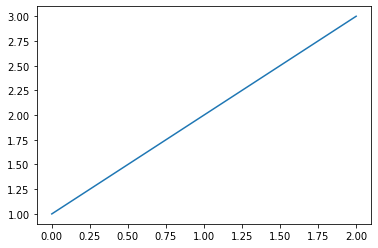

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([1, 2, 3])
plt.show()

In [ ]:
def execute(self, parameters, messages):
    """
    Executes the VegFrax Fractional Cover module.
    """

    # safe imports
    import os, sys                         
    import datetime                        
    import numpy as np                     
    import pandas as pd                    
    import tempfile                        

    # risk imports (non-native to arcgis)
    try:
        import xarray as xr
        import dask
    except Exception as e:
        arcpy.AddError('Python libraries xarray and dask not installed.')
        arcpy.AddMessage(str(e))
        return

    # import tools
    try:
        # shared folder
        sys.path.append(FOLDER_SHARED)
        import arc, satfetcher, tools  

        # module folder
        sys.path.append(FOLDER_MODULES)
        import vegfrax, cog  
    except Exception as e:
        arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
        arcpy.AddMessage(str(e))
        return

    # disable future warnings
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=RuntimeWarning)
    warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)

    # grab parameter values 
    in_low_nc = parameters[0].valueAsText             # raw input low res netcdf
    in_high_tif = parameters[1].valueAsText           # raw input high res tif
    out_nc = parameters[2].valueAsText                # output vegfrax netcdf
    in_agg_dates = parameters[3].value                # aggregate all dates
    in_start_date = parameters[4].value               # start date of aggregate
    in_end_date = parameters[5].value                 # end date of aggregate
    in_classes = parameters[6].valueAsText            # selected classes
    in_agg_classes = parameters[7].value              # aggregate selected classes       
    in_num_samples = parameters[8].value              # number of samples
    in_max_nodata = parameters[9].value               # max nodata frequency
    in_smooth = parameters[10].value                  # smooth output
    in_num_estimator = parameters[11].value           # number of model estimators
    in_criterion = parameters[12].value               # criterion type
    in_max_depth = parameters[13].value               # max tree depth
    in_max_features = parameters[14].value            # maximum features
    in_bootstrap = parameters[15].value               # boostrap
    in_fmask_flags = parameters[16].valueAsText       # fmask flag values
    in_max_cloud = parameters[17].value               # max cloud percentage
    in_add_result_to_map = parameters[18].value       # add result to map



    # # # # #
    # notify user and set up progress bar
    arcpy.AddMessage('Beginning VegFrax Fractional Cover.')
    arcpy.SetProgressor(type='step', 
                        message='Preparing parameters...', 
                        min_range=0, max_range=19)



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Loading and checking satellite NetCDF...')
    arcpy.SetProgressorPosition(1)

    try:
        # do quick lazy load of satellite netcdf for checking
        ds_low = xr.open_dataset(in_low_nc)
    except Exception as e:
        arcpy.AddWarning('Could not quick load input satellite NetCDF data.')
        arcpy.AddMessage(str(e))
        return

    # check xr type, vars, coords, dims, attrs
    if not isinstance(ds_low, xr.Dataset):
        arcpy.AddError('Input satellite NetCDF must be a xr dataset.')
        return
    elif len(ds_low) == 0:
        arcpy.AddError('Input NetCDF has no data/variables/bands.')
        return
    elif 'x' not in ds_low.dims or 'y' not in ds_low.dims or 'time' not in ds_low.dims:
        arcpy.AddError('Input satellite NetCDF must have x, y and time dimensions.')
        return
    elif 'x' not in ds_low.coords or 'y' not in ds_low.coords or 'time' not in ds_low.coords:
        arcpy.AddError('Input satellite NetCDF must have x, y and time coords.')
        return
    elif 'spatial_ref' not in ds_low.coords:
        arcpy.AddError('Input satellite NetCDF must have a spatial_ref coord.')
        return
    elif len(ds_low['x']) == 0 or len(ds_low['y']) == 0 or len(ds_low['time']) == 0:
        arcpy.AddError('Input satellite NetCDF must have all at least one x, y and time index.')
        return
    elif 'oa_fmask' not in ds_low and 'fmask' not in ds_low:
        arcpy.AddError('Expected cloud mask band not found in satellite NetCDF.')
        return
    elif not hasattr(ds_low, 'time.year') or not hasattr(ds_low, 'time.month'):
        arcpy.AddError('Input satellite NetCDF must have time with year and month component.')
        return
    elif ds_low.attrs == {}:
        arcpy.AddError('Satellite NetCDF must have attributes.')
        return
    elif not hasattr(ds_low, 'crs'):
        arcpy.AddError('Satellite NetCDF CRS attribute not found. CRS required.')
        return
    elif ds_low.crs != 'EPSG:3577':
        arcpy.AddError('Satellite NetCDF CRS is not in GDA94 Albers (EPSG:3577).')            
        return 
    elif not hasattr(ds_low, 'nodatavals'):
        arcpy.AddError('Satellite NetCDF nodatavals attribute not found.')            
        return 

    # efficient: if all nan, 0 at first var, assume rest same, so abort
    if ds_low[list(ds_low)[0]].isnull().all() or (ds_low[list(ds_low)[0]] == 0).all():
        arcpy.AddError('Satellite NetCDF has empty variables. Please download again.')            
        return 

    try:
        # now, do proper open of satellite netcdf properly (and set nodata to nan)
        ds_low = satfetcher.load_local_nc(nc_path=in_low_nc, 
                                          use_dask=True, 
                                          conform_nodata_to=np.nan)
    except Exception as e:
        arcpy.AddError('Could not properly load input satellite NetCDF data.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Getting NetCDF attributes...')
    arcpy.SetProgressorPosition(2)

    # get attributes from dataset
    ds_attrs = ds_low.attrs
    ds_band_attrs = ds_low[list(ds_low)[0]].attrs
    ds_spatial_ref_attrs = ds_low['spatial_ref'].attrs



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Grouping dates, if required...')
    arcpy.SetProgressorPosition(3)

    # remove potential datetime duplicates (group by day)
    ds_low = satfetcher.group_by_solar_day(ds_low)



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Reducing dataset dates, if requested...')
    arcpy.SetProgressorPosition(4)

    # check if dates are to be aggregated
    if in_agg_dates is None:
        arcpy.AddError('Must specify whether to aggregate dates or not.')
        return

    # if requested...
    if in_agg_dates is False:

        # check start and end dates 
        if in_start_date is None or in_end_date is None:
            arcpy.AddError('Did not provide a start or end date.')
            return

        # prepare start, end dates
        in_start_date = in_start_date.strftime('%Y-%m-%d')
        in_end_date = in_end_date.strftime('%Y-%m-%d')

        # check date range is valid
        if in_start_date >= in_end_date:
            arcpy.AddError('End date must be greater than start date.')
            return

        try:
            # subset to requested date range
            ds_low = vegfrax.subset_dates(ds=ds_low, 
                                          start_date=in_start_date,
                                          end_date=in_end_date)
        except Exception as e: 
            arcpy.AddError('Could not subset satellite NetCDF, see messages for details.')
            arcpy.AddMessage(str(e))
            return

        # check if any dates exist 
        if 'time' not in ds_low or len(ds_low['time']) == 0:
            arcpy.AddError('No dates exist in satellite NetCDF for requested date range.')
            return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Removing invalid pixels and empty dates...')
    arcpy.SetProgressorPosition(5)  

    # convert fmask as text to numeric code equivalents      
    in_fmask_flags = [e for e in in_fmask_flags.split(';')]        
    in_fmask_flags = arc.convert_fmask_codes(in_fmask_flags)

    # check if flags selected, if not, select all 
    if len(in_fmask_flags) == 0:
        arcpy.AddWarning('No flags set, selecting default')
        in_fmask_flags = [1, 4, 5]

    # check numeric flags are valid 
    for flag in in_fmask_flags:
        if flag not in [0, 1, 2, 3, 4, 5, 6]:
            arcpy.AddError('Pixel flag not supported.')
            return

    # check if duplicate flags 
    u, c = np.unique(in_fmask_flags, return_counts=True)
    if len(u[c > 1]) > 0:
        arcpy.AddError('Duplicate pixel flags detected.')
        return

    # check if mask band exists
    mask_band = arc.get_name_of_mask_band(list(ds_low))

    try:
        # remove invalid pixels and empty scenes
        ds_low = cog.remove_fmask_dates(ds=ds_low, 
                                        valid_class=in_fmask_flags, 
                                        max_invalid=in_max_cloud, 
                                        mask_band=mask_band, 
                                        nodata_value=np.nan, 
                                        drop_fmask=True)
    except Exception as e:
        arcpy.AddError('Could not cloud mask pixels.')
        arcpy.AddMessage(str(e))
        return

    # check if any dates remain 
    if 'time' not in ds_low or len(ds_low['time']) == 0:
        arcpy.AddError('No cloud-free data exists in satellite NetCDF for requested date range.')
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Conforming satellite band names...')
    arcpy.SetProgressorPosition(6)        

    try:
        # get platform name from attributes, error if no attributes
        in_platform = arc.get_platform_from_dea_attrs(ds_attrs)

        # conform dea aws band names based on platform
        ds_low = satfetcher.conform_dea_ard_band_names(ds=ds_low, 
                                                       platform=in_platform.lower())   
    except Exception as e: 
        arcpy.AddError('Could not get platform from attributes.')
        arcpy.AddMessage(str(e))
        return

    # check if all expected bands are in dataset 
    for band in ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']:
        if band not in ds_low:
            arcpy.AddError('Satellite NetCDF is missing band: {}. Need all bands.'.format(band))
            return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Calculating tasselled cap index...')
    arcpy.SetProgressorPosition(7)        

    try:
        # calculate tasselled cap green, bare, water
        ds_low = tools.calculate_indices(ds=ds_low, 
                                         index=['tcg', 'tcb', 'tcw'], 
                                         rescale=False, 
                                         drop=True)
    except Exception as e: 
        arcpy.AddError('Could not calculate tasselled cap index.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Reducing dataset into all-time median...')
    arcpy.SetProgressorPosition(8)

    try:
        # reduce into an all-time median 
        ds_low = vegfrax.reduce_to_median(ds=ds_low)

        # add band attrs back on
        ds_low['tcg'].attrs = ds_band_attrs   
        ds_low['tcb'].attrs = ds_band_attrs
        ds_low['tcw'].attrs = ds_band_attrs

    except Exception as e: 
        arcpy.AddError('Could not reduce satellite NetCDF to all-time median.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Computing satellite NetCDF into memory, please wait...')
    arcpy.SetProgressorPosition(9)

    try:
        # compute! 
        ds_low = ds_low.compute()
    except Exception as e: 
        arcpy.AddError('Could not compute satellite NetCDF. See messages for details.')
        arcpy.AddMessage(str(e))
        return

    # check if all nan again
    if ds_low.to_array().isnull().all():
        arcpy.AddError('Satellite NetCDF is empty. Please download again.')            
        return    



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Loading and checking classified GeoTiff...')
    arcpy.SetProgressorPosition(10)

    # check if type is geotiff 
    if not in_high_tif.endswith('.tif'):
        arcpy.AddError('High-resolution input is not a GeoTiff.')
        return

    try:
        # do quick lazy load of geotiff for checking
        ds_high = xr.open_rasterio(in_high_tif)
        ds_high = ds_high.to_dataset(dim='band')                  
    except Exception as e:
        arcpy.AddError('Could not quick load input classified GeoTiff.')
        arcpy.AddMessage(str(e))
        return

    # check xr type, vars, coords, dims, attrs
    if not isinstance(ds_high, xr.Dataset):
        arcpy.AddError('Input GeoTiff must be an xr dataset.')
        return
    elif len(ds_high) == 0:
        arcpy.AddError('Input GeoTiff has no data/variables/bands.')
        return
    elif len(ds_high) != 1:
        arcpy.AddError('Input GeoTiff has multiple bands.')
        return
    elif 'x' not in list(ds_high.coords) or 'y' not in list(ds_high.coords):
        arcpy.AddError('Input GeoTiff must have x, y coords.')
        return
    elif 'x' not in list(ds_high.dims) or 'y' not in list(ds_high.dims):
        arcpy.AddError('Input GeoTiff must have x, y dimensions.')
        return
    elif len(ds_high['x']) == 0 or len(ds_high['y']) == 0:
        arcpy.AddError('Input GeoTiff must have at least one x, y index.')
        return
    elif ds_high.attrs == {}:
        arcpy.AddError('GeoTiff attributes not found. GeoTiff must have attributes.')
        return
    elif not hasattr(ds_high, 'crs'):
        arcpy.AddError('GeoTiff CRS attribute not found. CRS required.')
        return
    elif '3577' not in ds_high.crs:
        arcpy.AddError('GeoTiff CRS is not EPSG:3577. EPSG:3577 required.')            
        return
    elif not hasattr(ds_high, 'nodatavals'):
        arcpy.AddError('GeoTiff nodatavals attribute not found.')            
        return
    elif 'int' not in str(ds_high.to_array().dtype):
        arcpy.AddError('GeoTiff is not an integer type. Please convert.')            
        return
    elif np.nan in ds_high.to_array():
        arcpy.AddError('GeoTiff contains reserved value nan. Please convert.')            
        return
    elif -999 in ds_high.to_array():
        arcpy.AddWarning('GeoTiff contains reserved value -999, will be considered as NoData.')            
        pass

    try:
        # do proper load with dask, set nodata to -999
        ds_high = satfetcher.load_local_rasters(rast_path_list=in_high_tif, 
                                                use_dask=True, 
                                                conform_nodata_to=-999)

        # rename first and only band, manually build attributes
        ds_high = ds_high.rename({list(ds_high)[0]: 'classes'})
        ds_high = tools.manual_create_xr_attrs(ds=ds_high)

    except Exception as e:
        arcpy.AddError('Could not properly load classified GeoTiff, see messages.')
        arcpy.AddMessage(str(e))
        return

    # check if not all nodata (-999)
    if (ds_high.to_array() == -999).all():
        arcpy.AddError('Input classified GeoTiff is completely empty.')            
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Clipping classified GeoTiff to satellite NetCDF...')
    arcpy.SetProgressorPosition(11)     

    # check extents overlap
    if not tools.all_xr_intersect([ds_low, ds_high]):
        arcpy.AddError('Not all input layers intersect.')            
        return 

    try:
        # clip classified geotiff extent to netcdf
        ds_high = tools.clip_xr_a_to_xr_b(ds_a=ds_high, 
                                          ds_b=ds_low)

    except Exception as e:
        arcpy.AddError('Could not clip GeoTiff to NetCDF, see messages for details.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Computing GeoTiff into memory, please wait...')
    arcpy.SetProgressorPosition(12)

    try:
        # compute geotiff! 
        ds_high = ds_high.compute()
    except Exception as e: 
        arcpy.AddError('Could not compute GeoTiff, see messages for details.')
        arcpy.AddMessage(str(e))
        return

    # ensure geotiff dataset still integer and not empty
    if 'int' not in str(ds_high.to_array().dtype):
        arcpy.AddError('GeoTiff was unable to maintain integer type.')            
        return 
    elif (ds_high.to_array() == -999).all():
        arcpy.AddError('GeoTiff is completely empty.')            
        return



    # # # # #
    # notify and set on-going progess bar
    arcpy.SetProgressor('default', 'Generating stratified random samples...')

    # ensure requested classes valid 
    if in_classes is None:
        arcpy.AddError('No classes were selected.')
        return

    # prepare requested classes from ui
    in_classes = in_classes.replace('Class: ', '').replace("'", '')
    in_classes = [int(c) for c in in_classes.split(';')]

    # get all available classes in dataset
    all_classes = list(np.unique(ds_high.to_array()))

    # clean and check both class arrays
    for arr in [in_classes, all_classes]:

        # remove nodata if exists
        if -999 in arr:
            arr.remove(-999)

        # check something remains 
        if arr is None or len(arr) == 0:
            arcpy.AddError('No classes were obtained from selection and/or dataset.')
            return

    # check if more than one non-nodata classes in geotiff 
    if len(all_classes) < 2:
        arcpy.AddError('More than one GeoTiff class required.')
        return

    # ensure all requested classes still available 
    for c in in_classes:
        if c not in all_classes:
            arcpy.AddError('Class {} not within satellite NetCDF extent.'.format(c))
            return

    # check number of samples 
    if in_num_samples < 1:
        arcpy.AddError('Number of samples must be 1 or more.')
        return

    try:
        # generate stratified random samples (number per class)
        df_samples = vegfrax.build_random_samples(ds_low=ds_low, 
                                                  ds_high=ds_high, 
                                                  classes=all_classes,
                                                  num_samples=in_num_samples)
    except Exception as e: 
        arcpy.AddError('Could not build random samples, see messages for details.')
        arcpy.AddMessage(str(e))
        return

    # warn (but continue) if undersampled 
    if len(df_samples) < len(all_classes) * in_num_samples:
        arcpy.AddWarning('Caution, smaller classes may be under-sampled.')



    # # # # #
    # notify and increment progess bar
    arcpy.SetProgressorLabel('Extracting tasselled cap values...')
    arcpy.SetProgressorPosition(13)

    try:
        # extract tasselled cap band values at each random sample
        df_samples = vegfrax.extract_xr_low_values(df=df_samples, 
                                                   ds=ds_low)
    except Exception as e: 
        arcpy.AddError('Could not extract values, see messages for details.')
        arcpy.AddMessage(str(e))
        return

    # ensure we have samples still 
    if len(df_samples) == 0:
        arcpy.AddError('No tasselled cap values were extracted.')
        return



    # # # # #
    # notify and increment progess bar
    arcpy.SetProgressorLabel('Building class fraction arrays...')
    arcpy.SetProgressorPosition(14)

    # ensure max nodata is valid 
    if in_max_nodata < 0 or in_max_nodata > 1:
        arcpy.AddError('Maximum NoData value must be >= 0 and <= 1.')
        return

    try:
        # build class fraction windows and arrays
        df_samples = vegfrax.build_class_fractions(df=df_samples, 
                                                   ds_low=ds_low, 
                                                   ds_high=ds_high, 
                                                   max_nodata=in_max_nodata)
    except Exception as e: 
        arcpy.AddError('Could not build class fraction arrays, see messages for details.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and set on-going progess bar
    arcpy.SetProgressor('default', 'Performing fractional cover analysis...')

    # check aggregate classes valid 
    if in_agg_classes not in [True, False]:
        arcpy.AddError('Combine classes is invalid.')
        return

    # check model parameters are valid
    if in_num_estimator < 1:
        arcpy.AddError('Number of model estimators not between 1 and 10000.')
        return
    elif in_criterion not in ['Mean Squared Error', 'Mean Absolute Error', 'Poisson']:
        arcpy.AddError('Criterion not supported.')
        return
    elif in_max_depth is not None and in_max_depth < 1:
        arcpy.AddError('Maximum depth must be empty or > 0.')
        return
    elif in_max_features not in ['Auto', 'Log2']:
        arcpy.AddError('Maximum features must be Auto or Log2.')
        return
    elif in_bootstrap not in [True, False]:
        arcpy.AddError('Boostrap must be either True or False.')
        return

    # prepare criterion value
    if 'Squared' in in_criterion:
        in_criterion = 'squared_error'
    elif 'Absolute' in in_criterion:
        in_criterion = 'absolute_error'
    else:
        in_criterion = 'poisson'

    # prepare options 
    options = {
        'n_estimators': in_num_estimator,
        'criterion': in_criterion,
        'max_depth': in_max_depth,
        'max_features': in_max_features.lower(),
        'bootstrap': in_bootstrap
    }

    try:
        # perform fca and accuracy result message
        ds_frax, result = vegfrax.perform_fcover_analysis(df=df_samples, 
                                                          ds=ds_low, 
                                                          classes=in_classes,
                                                          combine=in_agg_classes, 
                                                          options=options)
        # display accuracy results
        arcpy.AddMessage(result)
    except Exception as e:
        arcpy.AddError('Could not perform fractional cover analysis, see messages for details.')
        arcpy.AddMessage(str(e))
        return 

    # check frax dataset if all nan
    if ds_frax.to_array().isnull().all():
        arcpy.AddError('Fractional cover dataset result is empty.')            
        return 



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Smoothing dataset, if requested...')
    arcpy.SetProgressorPosition(15) 

    # check if smooth is valid 
    if in_smooth not in [True, False]:
        arcpy.AddError('Smooth output is invalid.')
        return

    # if requested...
    if in_smooth:
        try:
            # smooth via median filter
            ds_frax = vegfrax.smooth(ds_frax)
        except Exception as e:
            arcpy.AddError('Could not smooth dataset, see messages for details.')
            arcpy.AddMessage(str(e))
            return



    # # # # #
    # notify and increment progess bar
    arcpy.SetProgressorLabel('Appending attributes back on to dataset...')
    arcpy.SetProgressorPosition(16)

    # append attrbutes on to dataset and bands
    ds_frax.attrs = ds_attrs
    ds_frax['spatial_ref'].attrs = ds_spatial_ref_attrs
    for var in ds_frax:
        ds_frax[var].attrs = ds_band_attrs



    # # # # #
    # notify and increment progess bar
    arcpy.SetProgressorLabel('Exporting NetCDF file...')
    arcpy.SetProgressorPosition(17)   

    try:
        # export netcdf file
        tools.export_xr_as_nc(ds=ds_frax, filename=out_nc)
    except Exception as e:
        arcpy.AddError('Could not export dataset.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Adding output to map, if requested...')
    arcpy.SetProgressorPosition(18)

    # if requested...
    if in_add_result_to_map:
        try:
            # open current map
            aprx = arcpy.mp.ArcGISProject('CURRENT')
            m = aprx.activeMap

            # remove existing fractional layers if exist
            for layer in m.listLayers():
                if layer.isGroupLayer and layer.name == 'fractions':
                    m.removeLayer(layer)

            # setup a group layer via template
            grp_lyr = arcpy.mp.LayerFile(GRP_LYR_FILE)
            grp = m.addLayer(grp_lyr)[0]
            grp.name = 'fractions'

            # create output folder using datetime as name
            dt = datetime.datetime.now().strftime('%d%m%Y%H%M%S')
            out_folder = os.path.join(os.path.dirname(out_nc), 'fractions' + '_' + dt)
            os.makedirs(out_folder)

            # disable visualise on map temporarily
            arcpy.env.addOutputsToMap = False

            # iter each var and export a seperate tif
            tif_list = []
            for var in ds_frax:

                # create temp netcdf for one var (prevents 2.9 bug)
                with tempfile.NamedTemporaryFile() as tmp:
                    tmp_nc = '{}_{}.nc'.format(tmp.name, var)
                    ds_frax[[var]].to_netcdf(tmp_nc)

                # build in-memory crf for temp netcdf
                crf = arcpy.md.MakeMultidimensionalRasterLayer(in_multidimensional_raster=tmp_nc, 
                                                               out_multidimensional_raster_layer=var)

                # export temp tif
                tmp_tif = os.path.join(out_folder, '{}.tif'.format(var))
                tif = arcpy.management.CopyRaster(in_raster=crf, 
                                                  out_rasterdataset=tmp_tif)

                # add temp tif to map and get as layer
                m.addDataFromPath(tif)
                layer = m.listLayers('{}.tif'.format(var))[0]

                # hide layer once added
                #layer.visible = False

                # add layer to group and then remove outside layer
                m.addLayerToGroup(grp, layer, 'BOTTOM')
                m.removeLayer(layer) 

                # success, add store current layer for symbology below
                tif_list.append('{}.tif'.format(var))

        except Exception as e:
            arcpy.AddWarning('Could not visualise output, aborting visualisation.')
            arcpy.AddMessage(str(e))
            pass

        try:       
            # iter tif layer names and update symbology
            for tif in tif_list:
                layer = m.listLayers(tif)[0]
                sym = layer.symbology                    

                # if layer has stretch coloriser, apply color
                if hasattr(sym, 'colorizer'):
                    if sym.colorizer.type == 'RasterStretchColorizer':

                        # apply percent clip type and threshold 
                        sym.colorizer.stretchType = 'PercentClip'
                        sym.colorizer.minPercent = 0.1
                        sym.colorizer.maxPercent = 0.1

                        # create color map and apply
                        cmap = aprx.listColorRamps('Temperature')[0]                              
                        sym.colorizer.colorRamp = cmap

                        # apply other basic options
                        sym.colorizer.invertColorRamp = False
                        sym.colorizer.gamma = 1.0

                        # update symbology
                        layer.symbology = sym

                        # show layer 
                        #layer.visible = True

        except Exception as e:
            arcpy.AddWarning('Could not colorise output, aborting colorisation.')
            arcpy.AddMessage(str(e))
            pass



    # # # # #
    # clean up variables
    arcpy.SetProgressorLabel('Finalising process...')
    arcpy.SetProgressorPosition(19)

    # close and del dataset
    ds_low.close()
    ds_high.close()
    ds_frax.close()
    del ds_low
    del ds_high
    del ds_frax

    # notify user
    arcpy.AddMessage('Generated VegFrax successfully.')

    return

In [ ]:
# check extents overlap
if not tools.all_xr_intersect(ds_list):
    arcpy.AddError('Not all input layers intersect.')            
    return 

# check resample
if in_resample not in ['Lowest Resolution', 'Highest Resolution']:
    arcpy.AddError('Resample type not supported.')
    return

try:
    # select target resolution dataset
    ds_target = tools.get_target_res_xr(ds_list, 
                                        in_resample)
except Exception as e:
    arcpy.AddError('Could not get target GeoTiff resolution.')
    arcpy.AddMessage(str(e))
    return

# check target xr captured
if ds_target is None:
    arcpy.AddError('Could not obtain optimal GeoTiff resolution.')            
    return    

try:
    # resample all datasets to target dataset
    for idx in range(len(ds_list)):
        ds_list[idx] = tools.resample_xr(ds_from=ds_list[idx], 
                                         ds_to=ds_target,
                                         resampling='nearest')

        # squeeze to be safe!
        ds_list[idx] = ds_list[idx].squeeze(drop=True)
except Exception as e:
    arcpy.AddError('Could not resample GeoTiffs.')
    arcpy.AddMessage(str(e))
    return 




# # # # #
# notify and increment progess bar
arcpy.SetProgressorLabel('Combining GeoTiffs together...')
arcpy.SetProgressorPosition(4)

try:
    # merge vars into one dataset, fix attrs
    ds = xr.merge(ds_list)
    ds = tools.manual_create_xr_attrs(ds=ds)
except Exception as e:
    arcpy.AddError('Could not combine GeoTiffs.')
    arcpy.AddMessage(str(e))
    return 



# # # # #
# notify and increment progess bar
arcpy.SetProgressorLabel('Reducing data to smallest GeoTiff extent...')
arcpy.SetProgressorPosition(5)

try:
    # ensure bounding box is fixed to smallest mbr
    ds = tools.remove_nan_xr_bounds(ds=ds)
except Exception as e:
    arcpy.AddError('Could not reduce to smallest GeoTiff extent.')
    arcpy.AddMessage(str(e))           
    return    

# check if all nan again
if ds.to_array().isnull().all():
    arcpy.AddError('GeoTiff data is empty. Please check GeoTiffs.')            
    return 



# # # # #
# notify and increment progress bar
arcpy.SetProgressorLabel('Computing GeoTiffs into memory, please wait...')
arcpy.SetProgressorPosition(6)

try:
    # compute! 
    ds = ds.compute()
except Exception as e: 
    arcpy.AddError('Could not compute GeoTiffs. See messages for details.')
    arcpy.AddMessage(str(e))
    return    

# check if all nan again
if ds.to_array().isnull().all():
    arcpy.AddError('GeoTiff data is empty. Please check GeoTiffs.')            
    return 


In [ ]:
def execute(self, parameters, messages):
    """
    Executes the NRT Modify Monitoring Areas tool.
    """

    # safe imports
    import os
    import arcpy

    # risky imports
    try:
        import xarray as xr
    except Exception as e:
        arcpy.AddError('Could not import xarray module.')
        arcpy.AddMessage(str(e))
        return  

    # import tools
    try:
        # shared folder
        sys.path.append(FOLDER_SHARED)
        import arc

        # module folder
        sys.path.append(FOLDER_MODULES)
        import nrt
    except Exception as e:
        arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
        arcpy.AddMessage(str(e))
        return         

    # grab parameter values 
    in_feat = parameters[0]                           # input monitoring areas feature
    in_area_id = parameters[1].value                  # input monitoring area id
    in_platform = parameters[2].value                 # input platform
    in_s_year = parameters[3].value                   # input start year
    in_e_year = parameters[4].value                   # input end year
    in_veg_idx = parameters[5].value                  # input vegetation index
    in_persistence = parameters[6].value              # input persistence
    in_rule_1_min_conseqs = parameters[7].value       # input rule 1 min conseqs
    in_rule_1_inc_plateaus = parameters[8].value      # input rule 1 include plateaus
    in_rule_2_min_zone = parameters[9].value          # input rule 2 min stdvs
    in_rule_3_num_zones = parameters[10].value        # input rule 3 num zones 
    in_ruleset = parameters[11].value                 # input rulesets
    in_alert_user = parameters[12].value              # input alert user 
    in_alert_method = parameters[13].value            # input alert method 
    in_alert_direction = parameters[14].value         # input alert direction
    in_email = parameters[15].value                   # input email
    in_ignore = parameters[16].value                  # input ignore



    # # # # #
    # notify user and set up progress bar 
    arcpy.AddMessage('Beginning NRT Modify Monitoring Areas.')
    arcpy.SetProgressor(type='step',
                        message='Preparing parameters...',
                        min_range=0, max_range=7)



    # # # # #
    # notify user and increment progress bar 
    arcpy.SetProgressorLabel('Validating existing feature...') 
    arcpy.SetProgressorPosition(1) 

    # get full path to existing monitoring areas
    exist_feat_desc = arcpy.Describe(parameters[0].value)
    in_exist_feat = os.path.join(exist_feat_desc.path, exist_feat_desc.name)

    try:
        # check if input is valid (error if invalid)
        nrt.validate_monitoring_areas(in_exist_feat)
    except Exception as e:
        arcpy.AddError('Existing monitoring feature is incompatible, see messages for details.')
        arcpy.AddMessage(str(e))
        return 



    # # # # #
    # notify user and increment progress bar 
    arcpy.SetProgressorLabel('Validating new information...') 
    arcpy.SetProgressorPosition(2) 

    # set required fields 
    data = {
        'area_id':             in_area_id, 
        'platform':            in_platform, 
        's_year':              in_s_year, 
        'e_year':              in_e_year, 
        'index':               in_veg_idx,
        'persistence':         in_persistence,
        'rule_1_min_conseqs':  in_rule_1_min_conseqs,
        'rule_1_inc_plateaus': in_rule_1_inc_plateaus,
        'rule_2_min_zone':     in_rule_2_min_zone, 
        'rule_3_num_zones':    in_rule_3_num_zones,
        'ruleset':             in_ruleset,
        'alert':               in_alert_user,
        'method':              in_alert_method,
        'alert_direction':     in_alert_direction,
        'email':               in_email,
        'ignore':              in_ignore
        }

    try:
        # validate new area before insertion
        nrt.validate_monitoring_area(tuple(data.values()))
    except Exception as e:
        arcpy.AddError('Modified monitoring feature is incompatible, see messages for details.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify user and increment progress bar 
    arcpy.SetProgressorLabel('Updating feature...') 
    arcpy.SetProgressorPosition(3) 

    try:
        # open feature and update it at current id
        with arcpy.da.UpdateCursor(in_exist_feat, field_names=list(data.keys())) as cursor:
            for row in cursor:

                # update for current id
                if row[0] == in_area_id:
                    row[1] = data.get('platform')
                    row[2] = data.get('s_year')
                    row[3] = data.get('e_year')
                    row[4] = data.get('index')
                    row[5] = data.get('persistence')
                    row[6] = data.get('rule_1_min_conseqs')
                    row[7] = data.get('rule_1_inc_plateaus')
                    row[8] = data.get('rule_2_min_zone')
                    row[9] = data.get('rule_3_num_zones')
                    row[10] = data.get('ruleset')
                    row[11] = data.get('alert')
                    row[12] = data.get('method')
                    row[13] = data.get('alert_direction')
                    row[14] = data.get('email')
                    row[15] = data.get('ignore')

                    # update row
                    cursor.updateRow(row)
    except Exception as e:
        arcpy.AddError('Could not update existing feature.')
        arcpy.AddMessage(str(e))
        return



    # # # # #
    # notify user and increment progress bar 
    arcpy.SetProgressorLabel('Refreshing spatial index...') 
    arcpy.SetProgressorPosition(4)        

    try:
        # recalculate spatial index 
        arcpy.AddSpatialIndex_management(in_exist_feat)
    except Exception as e:
        arcpy.AddWarning('Could not refresh spatial index, skipping..')
        arcpy.AddMessage(str(e))
        pass   



    # # # # #
    # notify user and increment progress bar 
    arcpy.SetProgressorLabel('Removing features from map...') 
    arcpy.SetProgressorPosition(5) 

    try:           
        # for current project, open current map
        aprx = arcpy.mp.ArcGISProject('CURRENT')
        m = aprx.activeMap

        # remove all layers associated with monitoring areas
        for layer in m.listLayers():
            if layer.name == 'monitoring_areas':
                m.removeLayer(layer)
    except Exception as e:
        arcpy.AddWarning('Could not remove new feature from map, skipping.')
        arcpy.AddMessage(str(e))
        pass



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Adding output to map...')
    arcpy.SetProgressorPosition(6)

    try:           
        # for current project, open current map, re-add area feature
        aprx = arcpy.mp.ArcGISProject('CURRENT')
        m = aprx.activeMap
        m.addDataFromPath(in_exist_feat)

        # update all monitoring area features symbology
        for layer in m.listLayers('monitoring_areas'):
            arc.apply_monitoring_area_symbology(layer)

    except Exception as e:
        arcpy.AddWarning('Could not visualise output, aborting visualisation.')
        arcpy.AddMessage(str(e))
        pass

    try:
        # show labels
        for layer in m.listLayers('monitoring_areas'):
            label_class = layer.listLabelClasses()[0]
            label_class.expression = "'Zone: ' +  Text($feature.color_fill)"
            layer.showLabels = True
    except Exception as e:
        arcpy.AddWarning('Could not show labels, aborting label display.')
        arcpy.AddMessage(str(e))
        pass  



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Finalising process...')
    arcpy.SetProgressorPosition(7)

    # notify user
    arcpy.AddMessage('Modified existing NRT Monitoring Area.')

    return